In [1]:
import matplotlib
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal, bivariate_normal

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

#plt.rcParams['figure.figsize'] = (6, 6)
plot_dir = './plots/'
data_dir = './data/'

In [2]:
tc = test_case.TestCaseB()
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args)
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.run_simulation(label='default')

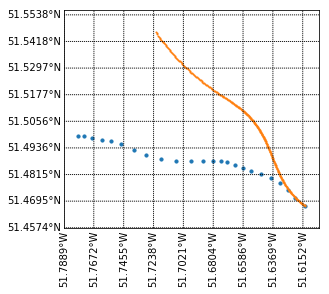

In [3]:
fig, ax = sim.results.plot(['reference', 'default'], sizes=[10, 1])

In [4]:
Ca, Cw = 0.01, 0.5
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 1}
labels = []
N = 40
for i in range(N):
    sim.run_simulation(label=f'{i}', **run_sim_kwargs)
    labels.append(f'{i}')
labels.append('reference')

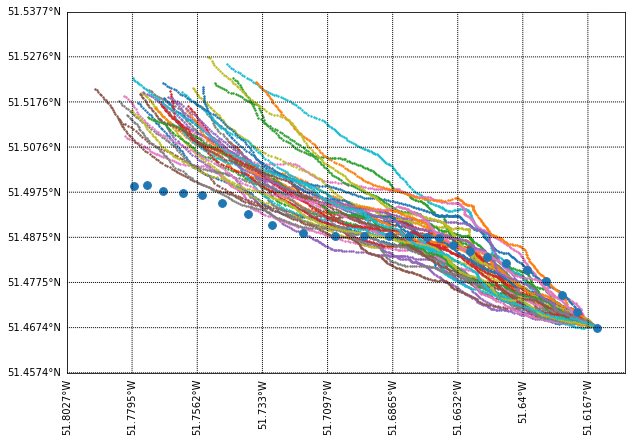

In [5]:
sizes = [2] * N + [60]
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = sim.results.plot(labels, sizes=sizes)#, labels=labels)

In [41]:
ts = sim.results.data['reference'].time.values
lats = sim.results.data['reference'].latitude.values
lons = sim.results.data['reference'].longitude.values
labels = [str(i) for i in range(N)]
sim_lats = np.empty((len(ts), len(labels)))
sim_lons = np.empty((len(ts), len(labels)))

for i in range(len(ts)):
    t = ts[i]
    for j, label in enumerate(labels):
        data = sim.results.data[label]
        sim_lats[i, j] = float(data['latitude'].interp(time=t, assume_sorted=True).values)
        sim_lons[i, j] = float(data['longitude'].interp(time=t, assume_sorted=True).values)

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:9: RankWarning: Polyfit may be poorly conditioned
  if __name__ == '__main__':
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/ipykernel_launcher.py:12: RankWarning: Polyfit may be poorly conditioned
  if sys.path[0] == '':


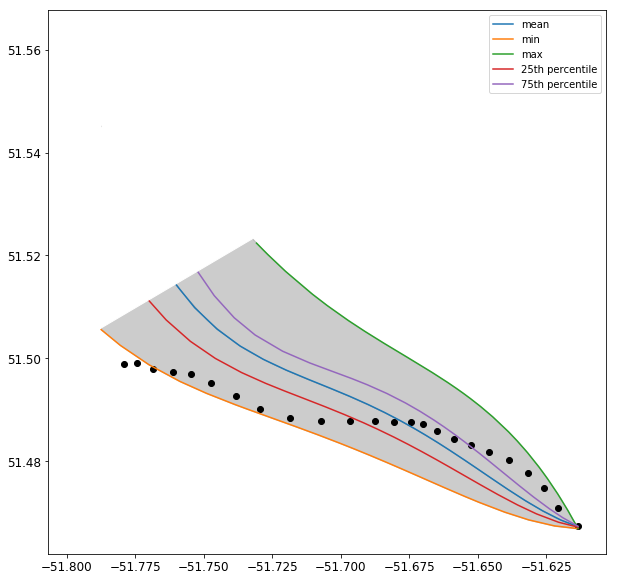

In [186]:
mean_lats = np.mean(sim_lats, axis=1); min_lats = np.min(sim_lats, axis=1); max_lats = np.max(sim_lats, axis=1);
mean_lons = np.mean(sim_lons, axis=1); min_lons = np.min(sim_lons, axis=1); max_lons = np.max(sim_lons, axis=1);
percentile25_lats = np.percentile(sim_lats, 25, axis=1)
percentile25_lons = np.percentile(sim_lons, 25, axis=1)
percentile75_lats = np.percentile(sim_lats, 75, axis=1)
percentile75_lons = np.percentile(sim_lons, 75, axis=1)

fit_params_mean = np.polyfit(mean_lons, mean_lats, 5)
fit_params_min = np.polyfit(min_lons, min_lats, 5)
fit_params_max = np.polyfit(max_lons, max_lats, 5)
fit_params_percentile25 = np.polyfit(percentile25_lons, percentile25_lats, 5)
fit_params_percentile75 = np.polyfit(percentile75_lons, percentile75_lats, 5)


plt.plot(mean_lons, np.polyval(fit_params_mean, mean_lons), label='mean')
plt.plot(min_lons, np.polyval(fit_params_min, min_lons), label='min')
plt.plot(max_lons, np.polyval(fit_params_max, max_lons), label='max')
plt.plot(percentile25_lons, np.polyval(fit_params_percentile25, percentile25_lons), label='25th percentile')
plt.plot(percentile75_lons, np.polyval(fit_params_percentile75, percentile75_lons), label='75th percentile')


plt.fill_between(mean_lons, np.polyval(fit_params_mean, mean_lons), np.polyval(fit_params_max, mean_lons), color='grey', alpha=0.4)
plt.fill_between(min_lons, np.polyval(fit_params_min, min_lons), np.polyval(fit_params_mean, min_lons), color='grey', alpha=0.4)

x = np.linspace(min_lons[-1]-0.01, max_lons[-1], 10)
y1 = (max_lats[-1] - min_lats[-1]) / ((max_lons[-1] - min_lons[-1])) * x + 67.773
y2 = (max_lats[-1] - min_lats[-1]) / ((max_lons[-1] - min_lons[-1])) * x + 67.812
plt.fill_between(x, y1, y2, color='white', zorder=4)


plt.scatter(lons, lats, color='k')

plt.legend()

# Perturb Current and Wind Velocities

In [90]:
def subset_ds(ds, bounds_by_colname):
    for colname, bounds in bounds_by_colname.items():
        ds = ds.where((ds[colname] >= bounds[0]) & (ds[colname] <= bounds[1]), drop=True)
    return ds

def get_bivariate_distribution(ds, field, time_bounds, latitude_bounds, longitude_bounds, return_uv=False):
    
    bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}
    sub_ds = subset_ds(ds, bounds_by_colname)    
    df = pd.DataFrame(columns=['t', 'x', 'y', 'u', 'v', 'iu', 'iv'])
        
    for i in range(len(sub_ds.time.values)):
        
        t = sub_ds.time.values[i]
        x = sub_ds.longitude.values[i]
        y = sub_ds.latitude.values[i]
        
        if len(sub_ds.eastward_velocity.shape) == 2:
            u = sub_ds.eastward_velocity.values[i, 0]
            v = sub_ds.northward_velocity.values[i, 0]
            
        else:
            u = sub_ds.eastward_velocity.values[i]
            v = sub_ds.northward_velocity.values[i]
            
        if np.isfinite(u):
            if np.isfinite(v):
                iu, iv = field.interpolate((t, y, x))
                df.loc[len(df)] = [t, x, y, float(u), float(v), float(iu), float(iv)]

    U1 = df.u.values
    V1 = df.v.values
    U2 = df.iu.values
    V2 = df.iv.values
    
    fit = fit_bivariate_normal(U1 - U2, V1 - V2)
    
    if return_uv:
        return fit, [U1, V1, U2, V2]
    
    else:
        return fit

In [91]:
def plot_data_with_bivariate_distribution(distribution_c, distribution_w, UV_c, UV_w):
    
    U_c1, V_c1, U_c2, V_c2 = UV_c
    U_w1, V_w1, U_w2, V_w2 = UV_w
    
    fig = plt.figure(figsize=(10, 10))
    i = 0
    for params in [distribution_c, distribution_w]:
        ellipse1 = Ellipse(xy=params[0], width=2*params[1], height=2*params[2], angle=np.rad2deg(params[3]), 
                          alpha=0.8, edgecolor='b', lw=4, facecolor='none')
        ellipse2 = Ellipse(xy=params[0], width=2*2*params[1], height=2*2*params[2], angle=np.rad2deg(params[3]), 
                      alpha=0.8, edgecolor='b', lw=4, facecolor='none')
        if i == 0:
            ax = fig.add_subplot(121, aspect='equal')
            ax.set_title('Current Correction Distribution')
        else:
            ax = fig.add_subplot(122, aspect='equal')
            ax.set_title('Wind Correction Distribution')
        ax.axhline(y=0, color='grey')
        ax.axvline(x=0, color='grey')
        ax.scatter(*params[0], color='k', zorder=2)
        ax.annotate(s=f'{np.round(params[0], 2)}', xy=(params[0][0], params[0][1]), fontsize=14)
        if i == 0:
            ax.scatter(U_c1 - U_c2, V_c1 - V_c2, color='r')
        else:
            ax.scatter(U_w1 - U_w2, V_w1 - V_w2, color='r')
        ax.add_artist(ellipse1)
        ax.add_artist(ellipse2)
        ax.set_xlabel('dU')
        ax.set_ylabel('dV')
        i+=1

    fig.tight_layout()

In [92]:
adcp_ds = sd.get_adcp_ds()
avos_ds = sd.get_avos_ds()

/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py:54: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=' ; ')


## +/- 10 days from start

In [7]:
start_time = tc.time_frame[0] - np.timedelta64(10, 'D')
end_time = tc.time_frame[1] + np.timedelta64(10, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

current_distribution, UV_c = get_bivariate_distribution(adcp_ds, metocean.Ocean(time_bounds, model='ECMWF').current,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

wind_distribution, UV_w = get_bivariate_distribution(avos_ds, metocean.Atmosphere(time_bounds).wind,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)
current_distribution, wind_distribution

(([0.030926678548224052, -0.01264596568056077],
  0.14013853473630547,
  0.09848249771882077,
  0.19383806680246585),
 ([-4.830874416867884, -0.7319703795914418],
  6.792599938118684,
  5.317590178194657,
  -0.45788678689115525))

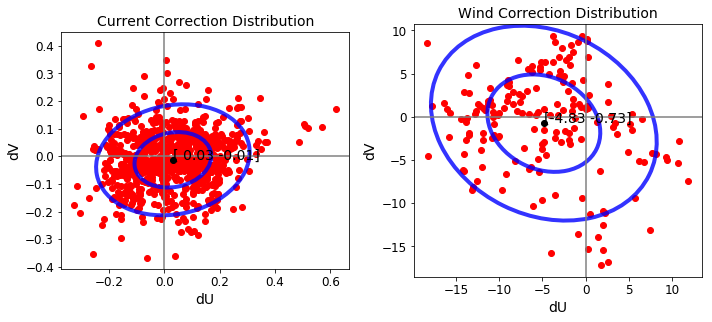

In [8]:
plot_data_with_bivariate_distribution(current_distribution, wind_distribution, UV_c, UV_w)

In [9]:
U_c1, V_c1, U_c2, V_c2 = UV_c 
dU_c = U_c1 - U_c2
dV_c = V_c1 - V_c2
df = pd.DataFrame(np.array([dU_c, dV_c]).T, columns=['dU', 'dV'])
df.to_csv('current_velocity_differences.csv')

U_w1, V_w1, U_w2, V_w2 = UV_w 
dU_w = U_w1 - U_w2
dV_w = V_w1 - V_w2
df = pd.DataFrame(np.array([dU_w, dV_w]).T, columns=['dU', 'dV'])
df.to_csv('wind_velocity_differences.csv')

In [47]:
speed_c1 = np.sqrt(U_c1**2 + V_c1**2)
speed_c2 = np.sqrt(U_c2**2 + V_c2**2)
speed_c = speed_c1 - speed_c2
direction_c1 = np.rad2deg(np.arctan2(U_c1, V_c1))
direction_c2 = np.rad2deg(np.arctan2(U_c2, V_c2))
angle_c = direction_c1 - direction_c2

for i, a in enumerate(angle_c): 
    if a > 180: 
        angle_c[i] -= 360
    elif a < -180:
        angle_c[i] += 360
        
speed_w1 = np.sqrt(U_w1**2 + V_w1**2)
speed_w2 = np.sqrt(U_w2**2 + V_w2**2)
speed_w = speed_w1 - speed_w2
direction_w1 = np.rad2deg(np.arctan2(U_w1, V_w1))
direction_w2 = np.rad2deg(np.arctan2(U_w2, V_w2))
angle_w = direction_w1 - direction_w2

for i, a in enumerate(angle_w): 
    if a > 180: 
        angle_w[i] -= 360
    elif a < -180:
        angle_w[i] += 360

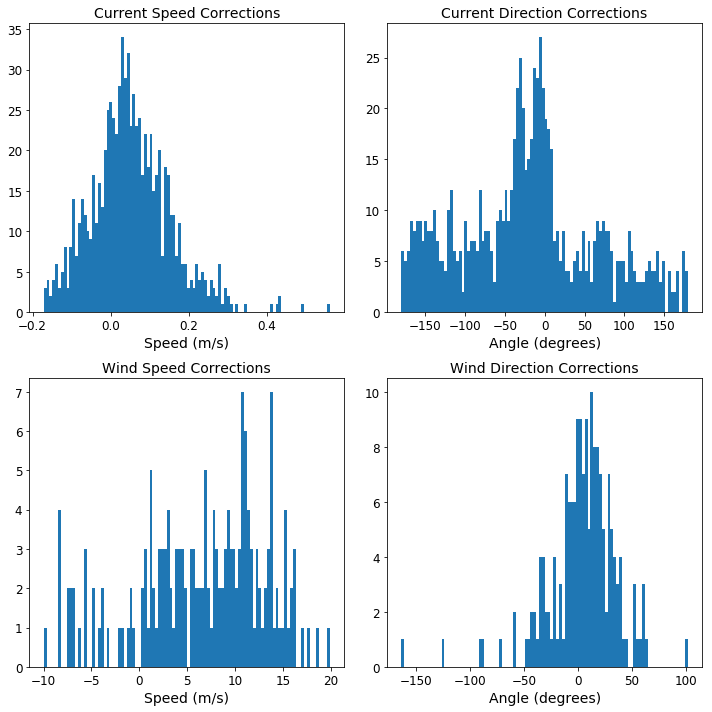

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].hist(speed_c, bins=100)
axes[0, 0].set_title('Current Speed Corrections')
axes[0, 0].set_xlabel('Speed (m/s)')

axes[0, 1].hist(angle_c, bins=100)
axes[0, 1].set_title('Current Direction Corrections')
axes[0, 1].set_xlabel('Angle (degrees)')

axes[1, 0].hist(speed_w, bins=100)
axes[1, 0].set_title('Wind Speed Corrections')
axes[1, 0].set_xlabel('Speed (m/s)')

axes[1, 1].hist(angle_w, bins=100)
axes[1, 1].set_title('Wind Direction Corrections')
axes[1, 1].set_xlabel('Angle (degrees)')

fig.tight_layout()

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

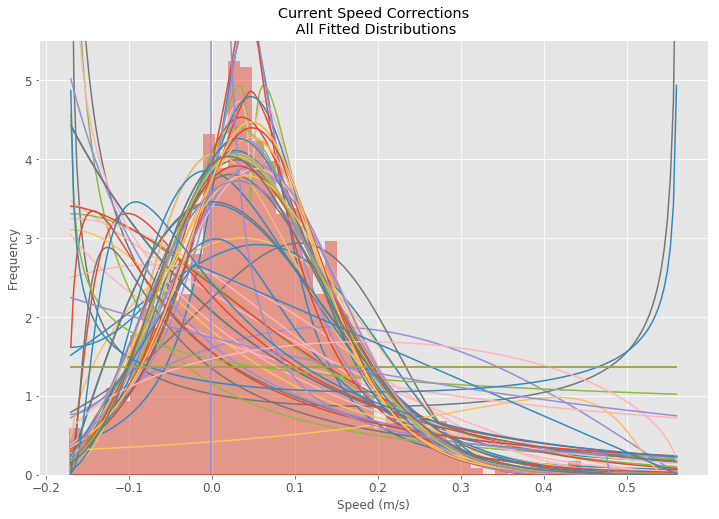

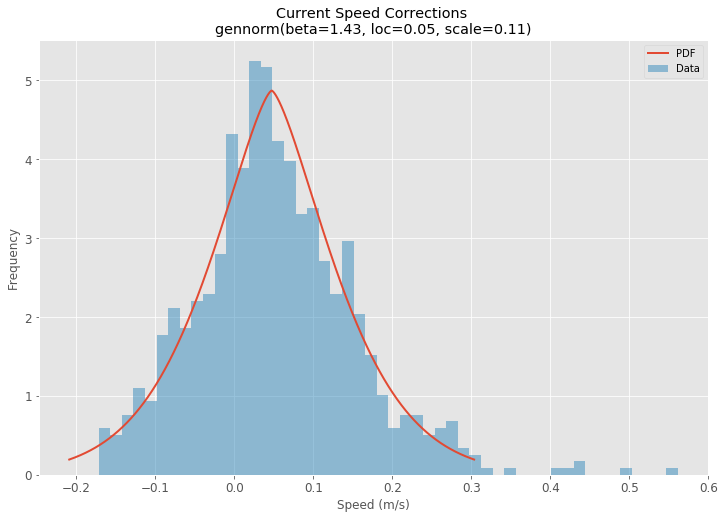

In [60]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = pd.Series(speed_c)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Current Speed Corrections\n All Fitted Distributions')
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Current Speed Corrections \n' + dist_str)
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

In [67]:
scipy.stats.gennorm.rvs(beta=1.43, loc=0.05, scale=0.11, size=10)

array([0.03385612, 0.0242569 , 0.01096704, 0.05410759, 0.13434438,
       0.41057846, 0.09303097, 0.06316217, 0.03136094, 0.07602124])

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

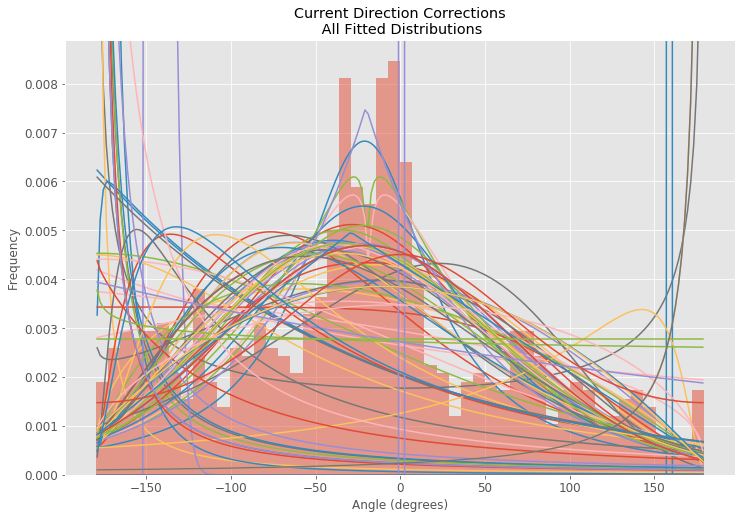

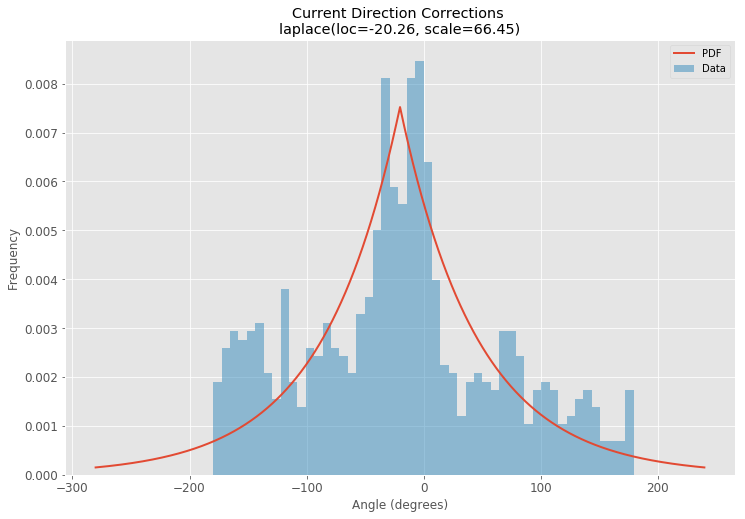

In [61]:
data = pd.Series(angle_c)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Current Direction Corrections\n All Fitted Distributions')
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Current Direction Corrections \n' + dist_str)
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

In [72]:
scipy.stats.laplace.rvs(loc=-20.26, scale=66.45, size=10)

array([ -50.42353926,   -0.38737154, -282.38025876,  -70.19928744,
         12.36845627,   27.18534238,  -53.99376527,  152.30956001,
       -197.9636201 , -128.90297819])

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

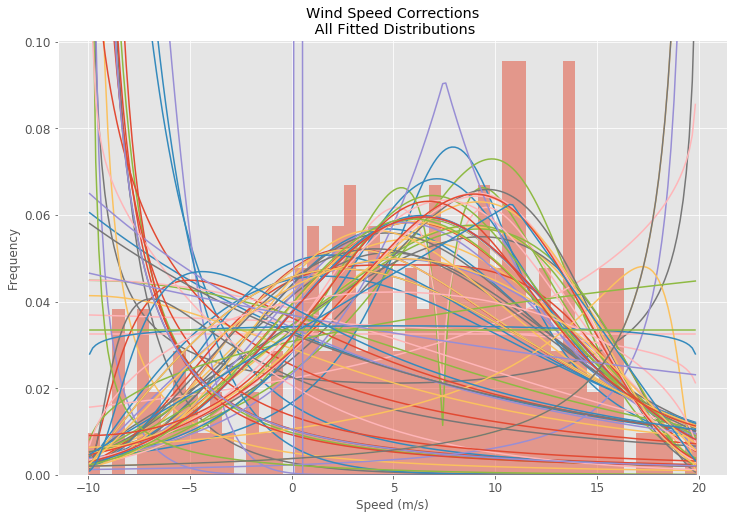

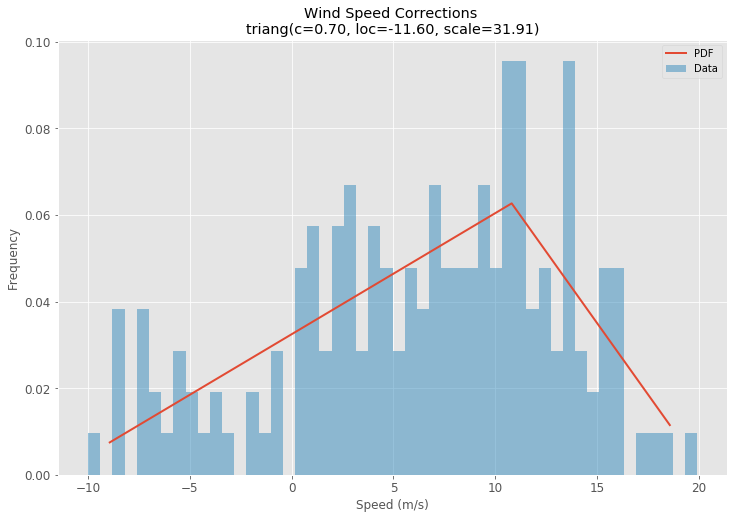

In [62]:
data = pd.Series(speed_w)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Wind Speed Corrections\n All Fitted Distributions')
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Wind Speed Corrections \n' + dist_str)
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Frequency')

In [69]:
scipy.stats.triang.rvs(c=0.70, loc=-11.60, scale=31.91, size=10)

array([17.97352126, 10.96928698, 10.00325103,  6.30436467, -8.7888963 ,
        1.80778318, 14.56655909, 13.9772861 , 10.59556168, 10.68382599])

/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/evankielley/anaconda3/envs/icedef/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

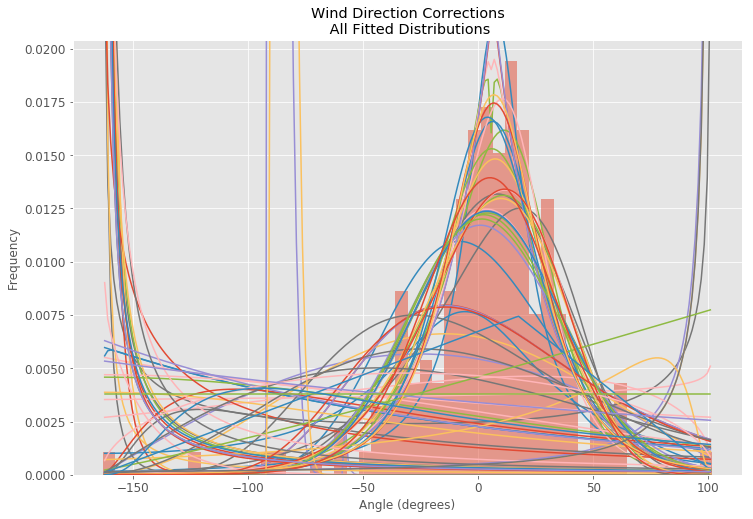

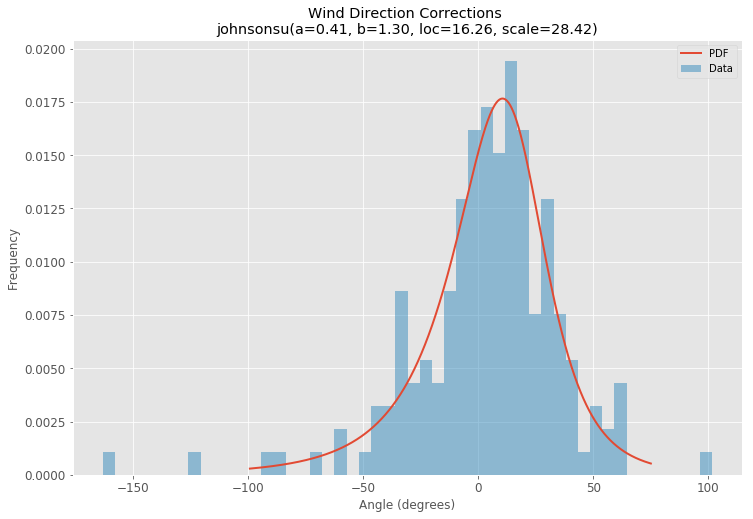

In [63]:
data = pd.Series(angle_w)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Wind Direction Corrections\n All Fitted Distributions')
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title('Wind Direction Corrections \n' + dist_str)
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')

In [71]:
scipy.stats.johnsonsu.rvs(a=0.41, b=1.30, loc=16.26, scale=28.42, size=10)

array([  40.96935884,   26.50381449,   31.33107052,    4.70890682,
       -112.330291  ,   -2.32828953,    3.02440866,   -4.19846313,
          5.08592955,  -18.87115839])

## +/- 1 day from start

In [119]:
start_time = tc.time_frame[0] - np.timedelta64(1, 'D')
end_time = tc.time_frame[1] + np.timedelta64(1, 'D')
time_bounds = start_time, end_time
latitude_bounds = 40, 60
longitude_bounds = -55, -50
bounds_by_colname = {'time': time_bounds, 'latitude': latitude_bounds, 'longitude': longitude_bounds}

current_distribution1, UV_c1 = get_bivariate_distribution(adcp_ds, metocean.Ocean(time_bounds, model='ECMWF').current,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

wind_distribution1, UV_w1 = get_bivariate_distribution(avos_ds, metocean.Atmosphere(time_bounds).wind,
                                                 time_bounds, latitude_bounds, longitude_bounds, 
                                                 return_uv=True)

current_distribution1, wind_distribution1

(([0.004259207031188701, -0.04021070540955816],
  0.1341277575544655,
  0.0985614055036261,
  0.11249854171764141),
 ([-9.888013671807787, 1.1123289370532514],
  4.197132312626123,
  2.834932361995365,
  0.43084340390637416))

In [138]:
scipy.stats.mstats.skewtest(np.array([dU_c, dV_c]).T)

SkewtestResult(statistic=masked_array(data=[3.0114886165473984, 0.21162301801284686],
             mask=[False, False],
       fill_value=1e+20), pvalue=array([0.0025997 , 0.83240115]))

In [135]:
scipy.stats.mstats.normaltest(np.array([dU_c, dV_c]).T)

NormaltestResult(statistic=masked_array(data=[12.517180084173853, 17.111127624477707],
             mask=[False, False],
       fill_value=1e+20), pvalue=array([0.00191394, 0.00019247]))

In [139]:
scipy.stats.skewnorm.fit(np.array([dU_c, dV_c]).T)

(1.3552759888642634, -0.09352583434539977, 0.16026121856611758)

In [140]:
p = scipy.stats.skewnorm.pdf(np.linspace(min(dU_c), max(dU_c), 100), *scipy.stats.skewnorm.fit(np.array([dU_c, dV_c]).T))

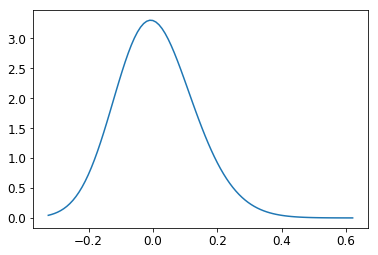

In [141]:
plt.plot(np.linspace(min(dU_c), max(dU_c), 100), p)

In [142]:
scipy.stats.ttest_rel(dU_c, dV_c)

Ttest_relResult(statistic=7.724892197252573, pvalue=3.332589062329984e-14)

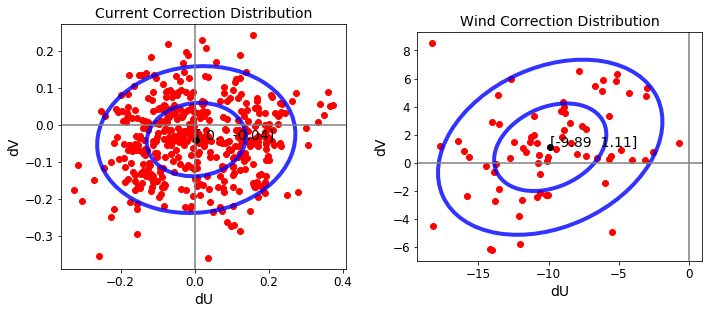

In [120]:
plot_data_with_bivariate_distribution(current_distribution1_, wind_distribution1_, UV_c1, UV_w1)

## Simulate Using Distributions for Corrections

In [81]:
sim.add_current_distribution(current_distribution)
sim.add_wind_distribution(wind_distribution)

In [85]:
Ca, Cw = 1, 0.75
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.5}
labels = ['reference']
for i in range(5):
    sim.run_simulation(label=f'{i}', **run_sim_kwargs)
    labels.append(f'{i}')

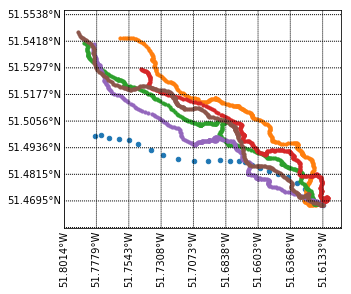

In [86]:
sizes = [20] + [10] * 10
#plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = sim.results.plot(labels, sizes=sizes)#, labels=labels)

In [17]:
forces = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy', 
                                         'Vwx', 'Vwy', 'Vcx', 'Vcy', 'Amwx', 'Amwy'])

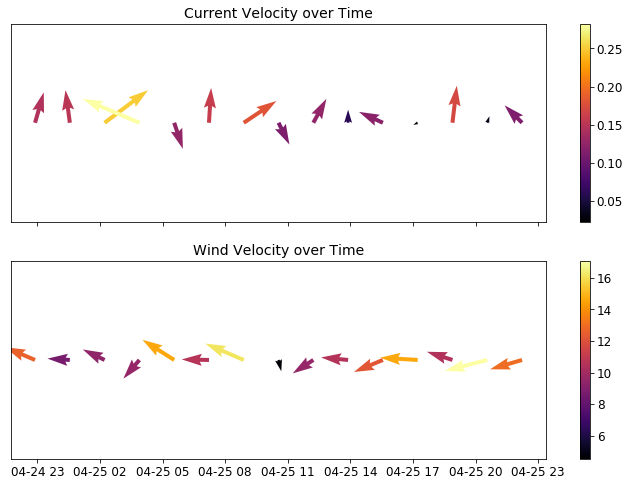

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
u = forces['Vcx'][::20].values
v = forces['Vcy'][::20].values

uv = np.sqrt(u**2 + v**2)
x = sim.results.data['0'].time.values[::20]
y = [0] * len(x)

norm = matplotlib.colors.Normalize()
norm.autoscale(uv)
cm = matplotlib.cm.inferno

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
ax1.quiver(x, y, u, v, color=cm(norm(uv)))
plt.colorbar(sm, ax=ax1)
ax1.set_title('Current Velocity over Time')
ax1.axes.get_yaxis().set_visible(False)

u = forces['Vwx'][::20].values
v = forces['Vwy'][::20].values
uv = np.sqrt(u**2 + v**2)
norm = matplotlib.colors.Normalize()
norm.autoscale(uv)
cm = matplotlib.cm.inferno

sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
ax2.quiver(x, y, u, v, color=cm(norm(uv)))
plt.colorbar(sm, ax=ax2)
ax2.set_title('Wind Velocity over Time')
ax2.axes.get_yaxis().set_visible(False)

plt.show()

In [88]:
sim.add_current_distribution(current_distribution1)
sim.add_wind_distribution(wind_distribution1)

In [96]:
Ca, Cw = 1.5, 1.5
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.5}
labels = []
N = 10
for i in range(N):
    sim.run_simulation(label=f'{i}', **run_sim_kwargs)
    labels.append(f'{i}')
labels.append('reference')

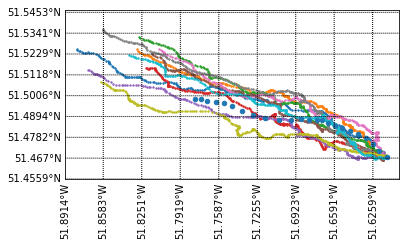

In [99]:
sizes = [2] * N + [20]
#plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = sim.results.plot(labels, sizes=sizes)#, labels=labels)

# Optimizing Ca and Cw

### Scipy minimize

In [290]:
run_optimization = False

if not run_optimization:
    optimization_result = type('dummy', (object,), {})()
    optimization_result.x = np.array([9.15857407, 1.94167373])
    
else:
    
    keys = ['Ca', 'Cw']
    x0 = [1, 1]
    bounds = [[0.01, 15], [0.01, 15]]
    reference_vectors = [tc.ref_lats, tc.ref_lons]
    optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

optimization_result.x

array([9.15857407, 1.94167373])

In [291]:
Ca, Cw = optimization_result.x
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
sim.run_simulation(label='optimized', **run_sim_kwargs)

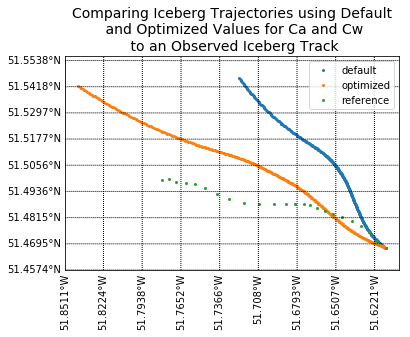

In [292]:
title = 'Comparing Iceberg Trajectories using Default\n and Optimized Values for Ca and Cw\n to an Observed Iceberg Track'
sizes = 4
legend_kwargs = {'loc': 1}
kwargs = {'title': title, 'sizes': sizes, 'legend_kwargs': legend_kwargs}
fig, ax = sim.results.plot(['default', 'optimized', 'reference'], labels=['default', 'optimized', 'reference'], 
                         **kwargs)
fig.savefig(plot_dir + 'tracks_from_default_and_optimized_Ca_and_Cw.png', bbox_inches='tight')

### Brute force

In [24]:
Ca_num = 16
Cw_num = 16
Ca_lower_bound = 0.1; Ca_upper_bound = 15
Cw_lower_bound = 0.1; Cw_upper_bound = 15

data_filename = data_dir + f'mses_for_Ca_{Ca_lower_bound}-{Ca_upper_bound}_and_Cw_{Cw_lower_bound}-{Cw_upper_bound}.npy'

try:
    mse_matrix = np.load(data_filename)

except FileNotFoundError:
    
    scaling = 'lin'

    if scaling == 'log':

        Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
        Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

    elif scaling == 'lin':

        Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
        Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


    Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

    mse_matrix = np.zeros((Ca_num, Cw_num))
    keys = ['Ca', 'Cw']
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    for i in range(Ca_num):
        for j in range(Cw_num):
            form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
            mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)
            
    np.save(data_filename, mse_matrix)

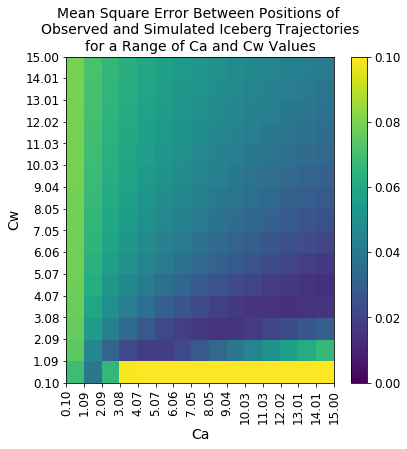

In [25]:
fig = plt.figure(figsize=(6,6))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0, vmax=0.1)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.title('Mean Square Error Between Positions of \n'+ \
          'Observed and Simulated Iceberg Trajectories\n' + \
          'for a Range of Ca and Cw Values')

plt.colorbar()

plt.show()

fig.savefig(plot_dir + 'mse_color_plot.png', bbox_inches='tight')

# Distance Between Observed and Optimized Tracks

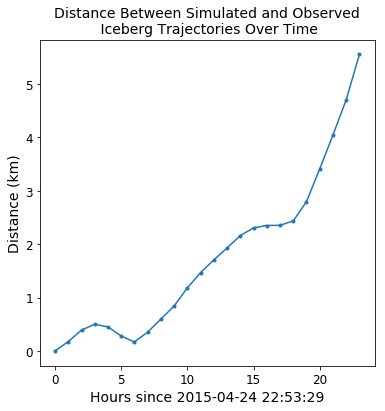

In [253]:
norms = sim.results.compute_distance_between_two_tracks('reference', 'optimized')
plt.plot(norms, '.-')
plt.ylabel('Distance (km)')
plt.xlabel('Hours since {}'.format(pd.Timestamp(tc.ref_times[0])))
plt.title('Distance Between Simulated and Observed\n Iceberg Trajectories Over Time')
plt.show()

# Varying size while using optimal drag coefficients

In [342]:
sim.time_stepper = timesteppers.rk4
sim.iceberg_size = 1000, 300 # VLG
sim.run_simulation(label='vlg_optimized', **{'Ca': Ca, 'Cw': Cw})
sim.iceberg_size = 60, 120 # MED
sim.run_simulation(label='med_optimized', **{'Ca': Ca, 'Cw': Cw})
sim.iceberg_size = 40, 80 # SM
sim.run_simulation(label='sm_optimized', **{'Ca': Ca, 'Cw': Cw})

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2591d7cba8>)

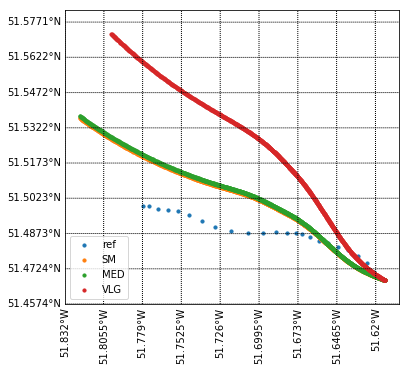

In [343]:
sim.results.plot(['reference', 'sm_optimized', 'med_optimized', 'vlg_optimized'], 
                 labels=['ref', 'SM', 'MED', 'VLG'], sizes=10)

In [337]:
keys = ['Ca', 'Cw', 'waterline_length', 'sail_height']
x0 = [1, 1, 120, 60]
#bounds = [[0.01, 15], [0.01, 15], [80, 160], [40, 80]]
bounds = [[1, 10], [1, 10], [80, 160], [40, 80]]
reference_vectors = [tc.ref_lats, tc.ref_lons]
sim.time_stepper = timesteppers.euler
sim.time_step = np.timedelta64(100, 's')
optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors, 
                                           optimizer='differential_evolution', **{'maxiter': 1})

In [338]:
optimization_result

     fun: 0.013584061209369419
     jac: array([1.49649390e-05, 2.05912544e-04, 1.38403178e-05, 0.00000000e+00])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 230
     nit: 1
 success: False
       x: array([  9.42608308,   2.46374446, 110.90713947,  56.83006815])

In [340]:
Ca, Cw, waterline_length, sail_height = optimization_result.x
kwargs = {'Ca': Ca, 'Cw': Cw, 'waterline_length': waterline_length, 'sail_height': sail_height}
sim.run_simulation(label='optimized_Ca_Cw_and_size', **kwargs)

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f25b024af98>)

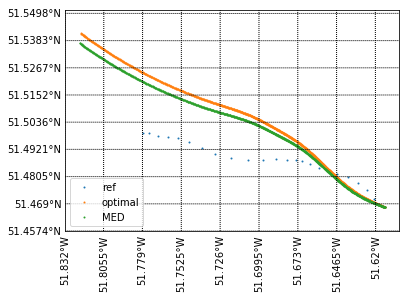

In [345]:
sim.results.plot(['reference', 'optimized_Ca_Cw_and_size', 'med_optimized'], labels=['ref', 'optimal', 'MED'])